# Mini Projet - GridWorld pour un Deep Q-Network et agent suppervisé de classification Florian Touraine - Clara Sithidej

In [1]:
from game.gridword import *
from dqn.dqn_agent import *
from ClassificationEnv import *

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
import numpy as np
import pygame
import torch
import time

/Users/Florian/Documents/Ecole/UQAC/Cours-Obsidian/Cours/Cours - UQAC/Fondamentaux de l apprentissage automatique/projets/Gridword/venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Question 2.4

On entraine notre DQN sur notre environnement Gridworld

In [20]:
env = GridWorld5x5()
state = env.reset()

done = False

print("=== DÉBUT DE L'ENTRAINEMENT DQN ===")
rewards = train_dqn(env, episodes=2000)
print("=== FIN DE L'ENTRAINEMENT DQN ===")

=== DÉBUT DE L'ENTRAINEMENT DQN ===
Episode 1/200 - Reward: -10.30 - Epsilon: 0.995
Episode 2/200 - Reward: -10.70 - Epsilon: 0.990
Episode 3/200 - Reward: -13.10 - Epsilon: 0.985
Episode 4/200 - Reward: -10.90 - Epsilon: 0.980
Episode 5/200 - Reward: -10.10 - Epsilon: 0.975
Episode 6/200 - Reward: -10.70 - Epsilon: 0.970
Episode 7/200 - Reward: -11.10 - Epsilon: 0.966
Episode 8/200 - Reward: -10.10 - Epsilon: 0.961
Episode 9/200 - Reward: -10.70 - Epsilon: 0.956
Episode 10/200 - Reward: -10.40 - Epsilon: 0.951
Episode 11/200 - Reward: -10.90 - Epsilon: 0.946
Episode 12/200 - Reward: -13.20 - Epsilon: 0.942
Episode 13/200 - Reward: -10.70 - Epsilon: 0.937
Episode 14/200 - Reward: -11.00 - Epsilon: 0.932
Episode 15/200 - Reward: -10.60 - Epsilon: 0.928
Episode 16/200 - Reward: -10.60 - Epsilon: 0.923
Episode 17/200 - Reward: -11.40 - Epsilon: 0.918
Episode 18/200 - Reward: -11.40 - Epsilon: 0.914
Episode 19/200 - Reward: -10.20 - Epsilon: 0.909
Episode 20/200 - Reward: -12.10 - Epsilon:

On regarde sa courbe d'apprentissage

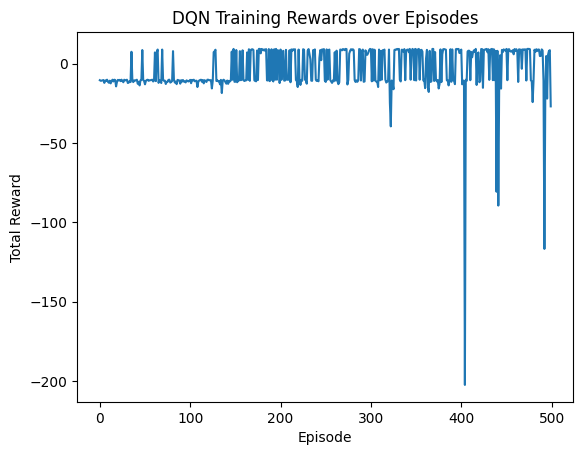

In [3]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Rewards over Episodes')
plt.show()

In [4]:
# ON CREER NOTRE AGENT
initial_state = env.reset()
agent = DQNAgent(env.state_size, env.action_size)

# CHARGEMENT MODÈLE 
model_path = "models/dqn_gridword.pth"
device = torch.device("cpu") # CPU obligatoire pour éviter les conflits
agent.device = device
agent.q_network.to(device)

try:
    agent.q_network.load_state_dict(
        torch.load(model_path, map_location=device)
    )
    agent.q_network.eval()
    print("Modèle DQN chargé avec succès")
except FileNotFoundError:
    print(f"Modèle introuvable : {model_path}")
    pygame.quit()
    raise SystemExit

Modèle DQN chargé avec succès


## Question 2.5 : On va evaluer le modèle à l'aide d'une fonction

In [5]:
def evaluate_agent(env, agent, n_episodes=50):
    """
    Évalue les performances de l'agent sur n_episodes avec affichage Pygame optionnel,
    et calcule le pourcentage de survie (épisodes terminés sans mourir).
    
    Args:
        env: environnement GridWorld5x5
        agent: DQNAgent
        n_episodes: nombre d'épisodes pour l'évaluation
    """
    print(f"--- Démarrage de l'évaluation sur {n_episodes} épisodes ---")
    
    # Sauvegarder l'epsilon actuel et le mettre à 0 pour test (exploitation pure)
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0
    agent.q_network.eval()
    
    total_rewards = []
    steps_survived = []
    survived_flags = []  # True si l'agent n'est pas mort, False sinon

    clock = pygame.time.Clock()
    
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_steps = 0
        
        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            
            state = next_state
            episode_reward += reward
            episode_steps += 1

        survived = env.success
        survived_flags.append(survived)

        # Fin d'épisode
        total_rewards.append(episode_reward)
        steps_survived.append(episode_steps)
        
        print(f"Episode {episode+1}/{n_episodes} - Reward: {episode_reward:.2f} - Steps: {episode_steps} - Survived: {survived}")

    # Restaurer epsilon et mode entraînement
    agent.epsilon = original_epsilon
    agent.q_network.train()
    
    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(steps_survived)
    survival_rate = np.mean(survived_flags) * 100
    
    print("\n=== RÉSULTATS DE L'ÉVALUATION ===")
    print(f"Reward Moyenne       : {avg_reward:.2f}")
    print(f"Survie Moyenne       : {avg_steps:.1f} steps")
    print(f"Taux de survie       : {survival_rate:.1f}%")
    
    return total_rewards, survived_flags


Une fois la fonction crée on va lance sur notre environnement

--- Démarrage de l'évaluation sur 50 épisodes ---
Episode 1/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 2/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 3/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 4/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 5/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 6/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 7/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 8/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 9/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 10/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 11/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 12/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 13/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 14/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 15/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 16/50 - Reward: 9.30 - Steps: 8 - Survived: True
Episode 17/50 - Reward: 9.30 - Steps: 8 - Survi

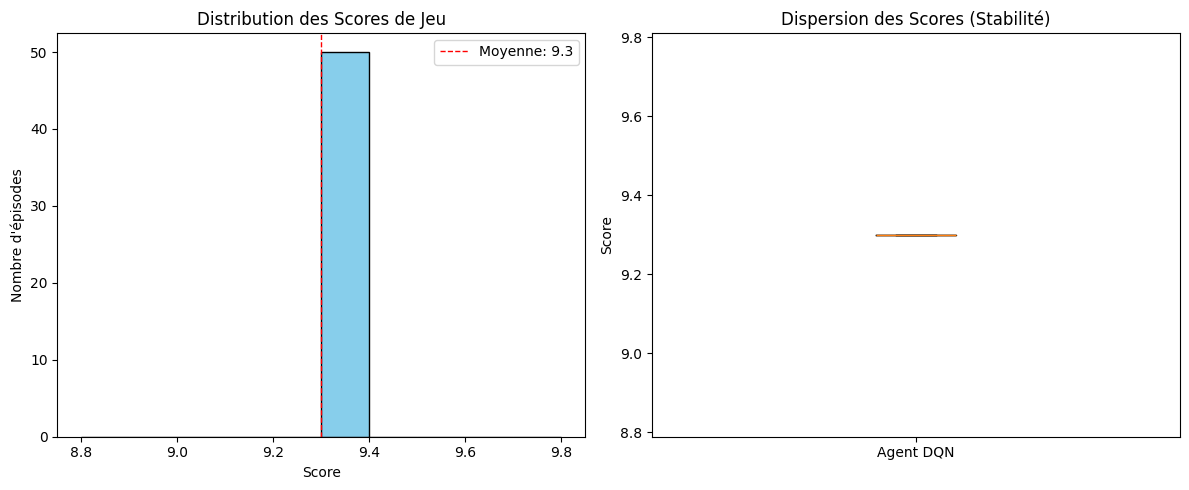

In [6]:
#Exécution de l'évaluation
test_scores, test_rewards = evaluate_agent(env, agent, n_episodes=50)

# Visualisation Graphique
plt.figure(figsize=(12, 5))

# 1. Histogramme des scores
plt.subplot(1, 2, 1)
plt.hist(test_scores, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution des Scores de Jeu')
plt.xlabel('Score')
plt.ylabel('Nombre d\'épisodes')
plt.axvline(np.mean(test_scores), color='red', linestyle='dashed', linewidth=1, label=f'Moyenne: {np.mean(test_scores):.1f}')
plt.legend()

# 2. Boxplot (pour voir la stabilité)
plt.subplot(1, 2, 2)
plt.boxplot(test_scores)
plt.title('Dispersion des Scores (Stabilité)')
plt.ylabel('Score')
plt.xticks([1], ['Agent DQN'])

plt.tight_layout()
plt.show()

## Question 2.6 : On va créer des données synthétiques afin d'entrainer un agent suppervisé de classification

In [7]:
# CONFIGURATION DU GRIDWORLD
# 0: Vide, 1: Obstacle, 2: But (Goal)
grid = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 2] 
])

def get_path_bfs(start, goal, grid):
    queue = deque([(start, [])])
    visited = {start}
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)] # Haut, Bas, Gauche, Droite
    while queue:
        (r, c), path = queue.popleft()
        if (r, c) == goal: return path[0] if path else None
        for i, (dr, dc) in enumerate(moves):
            nr, nc = r + dr, c + dc
            if 0 <= nr < 5 and 0 <= nc < 5 and grid[nr, nc] != 1 and (nr, nc) not in visited:
                visited.add((nr, nc))
                queue.append(((nr, nc), path + [i]))
    return None

# Génération massive des données
n_augment = 100 # Nombre de variations par case
data = []
goal_pos = (4, 4)

for r in range(5):
    for c in range(5):
        if grid[r, c] == 0:
            action = get_path_bfs((r, c), goal_pos, grid)
            if action is not None:
                for _ in range(n_augment):
                    # Ajout d'un petit bruit pour multiplier les données
                    noise_r = r + np.random.normal(0, 0.05)
                    noise_c = c + np.random.normal(0, 0.05)
                    data.append([noise_r, noise_c, action])

df = pd.DataFrame(data, columns=['pos_x', 'pos_y', 'label_action'])
df.to_csv("dataset_grid_fixe.csv", index=False)
print(f"Dataset créé : {len(df)} lignes basées sur une seule grille.")

Dataset créé : 2100 lignes basées sur une seule grille.


On visualise nos données

In [8]:
df.head()

,pos_x,pos_y,label_action
0,0.033046,-0.019848,1
1,0.017540,0.061700,1
2,0.050022,-0.092662,1
3,0.045972,0.059343,1
4,0.019049,-0.017605,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pos_x         2100 non-null   float64
 1   pos_y         2100 non-null   float64
 2   label_action  2100 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 49.3 KB


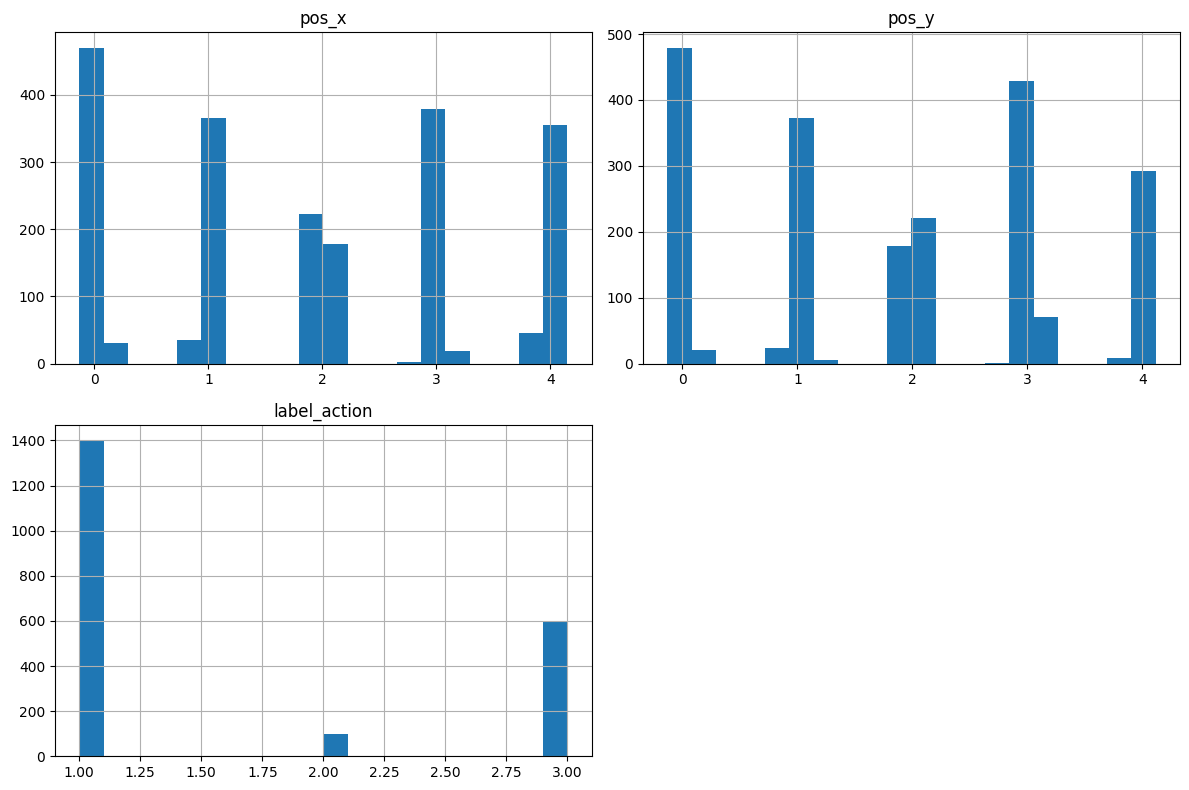

In [10]:
df.hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

On va passer à l'entrainement sur nos données

In [11]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=5)

In [12]:
# Préparation Train
X_train = train_set.drop("label_action", axis=1)
Y_train = train_set["label_action"]

# 2. Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [13]:
# 3. Modèle d'agent-supervisé (Question 2.6) 
clf = MLPClassifier(hidden_layer_sizes=(128, 128), 
                    activation='relu', 
                    solver='adam', 
                    max_iter=10,
                    verbose=True)

# 4. Entraînement et Chronométrage (Question 2.7) 
start_time = time.time()
clf.fit(X_train_scaled, Y_train)
end_time = time.time()

Iteration 1, loss = 0.89962486
Iteration 2, loss = 0.68383808
Iteration 3, loss = 0.59202789
Iteration 4, loss = 0.52962552
Iteration 5, loss = 0.47833688
Iteration 6, loss = 0.43222147
Iteration 7, loss = 0.39036491
Iteration 8, loss = 0.34851574
Iteration 9, loss = 0.31008404
Iteration 10, loss = 0.27371507


/Users/Florian/Documents/Ecole/UQAC/Cours-Obsidian/Cours/Cours - UQAC/Fondamentaux de l apprentissage automatique/projets/Gridword/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


## Question 2.7 : On va mesurer les performances de notre agent

On évalue sur les données tests

In [14]:

X_test = test_set.drop("label_action", axis=1)
Y_test = test_set["label_action"]

# Utiliser uniquement .transform() sur le test
X_test_scaled = scaler.transform(X_test) 

In [15]:
# 5. Mesure des performances 
accuracy = clf.score(X_test_scaled, Y_test)
training_time = end_time - start_time

print(f"--- Résultats de l'agent-supervisé ---")
print(f"Accuracy (Exactitude) : {accuracy * 100:.2f}%") 
print(f"Temps d'entraînement : {training_time:.2f} s")

--- Résultats de l'agent-supervisé ---
Accuracy (Exactitude) : 88.33%
Temps d'entraînement : 0.05 s


## Qestion 2.8 : On créer un environnement pour un DQN qui fait de la classification 

In [16]:
# Initialiser l'environnement de classification
env_classif = ClassificationEnv(X_train_scaled, Y_train.values)

# Entraîner l'agent-DQN sur la tâche de classification
start_dqn = time.time()
history_dqn = train_dqn(env_classif, episodes=100)
time_dqn = time.time() - start_dqn 

Episode 1/100 - Reward: -777.00 - Epsilon: 0.995
Episode 2/100 - Reward: -843.00 - Epsilon: 0.990
Episode 3/100 - Reward: -791.00 - Epsilon: 0.985
Episode 4/100 - Reward: -789.00 - Epsilon: 0.980
Episode 5/100 - Reward: -789.00 - Epsilon: 0.975
Episode 6/100 - Reward: -721.00 - Epsilon: 0.970
Episode 7/100 - Reward: -723.00 - Epsilon: 0.966
Episode 8/100 - Reward: -757.00 - Epsilon: 0.961
Episode 9/100 - Reward: -749.00 - Epsilon: 0.956
Episode 10/100 - Reward: -723.00 - Epsilon: 0.951
Episode 11/100 - Reward: -677.00 - Epsilon: 0.946
Episode 12/100 - Reward: -663.00 - Epsilon: 0.942
Episode 13/100 - Reward: -693.00 - Epsilon: 0.937
Episode 14/100 - Reward: -715.00 - Epsilon: 0.932
Episode 15/100 - Reward: -681.00 - Epsilon: 0.928
Episode 16/100 - Reward: -619.00 - Epsilon: 0.923
Episode 17/100 - Reward: -635.00 - Epsilon: 0.918
Episode 18/100 - Reward: -643.00 - Epsilon: 0.914
Episode 19/100 - Reward: -675.00 - Epsilon: 0.909
Episode 20/100 - Reward: -603.00 - Epsilon: 0.905
Episode 2

## Question 2.9 : On evalue notre modèle en le comparant avec notre agent suppervisé 

In [17]:
def evaluate_dqn(agent, X_test, Y_test):
    """
    Calcule l'accuracy de l'agent DQN sur un jeu de test.
    """
    agent.q_network.eval() # Mode évaluation (désactive dropout/batchnorm si présents)
    correct_predictions = 0
    total_samples = len(X_test)

    with torch.no_grad(): # Pas de calcul de gradient pour l'inférence
        for i in range(total_samples):
            # Préparation de l'état (tenseur)
            state = torch.FloatTensor(X_test[i]).unsqueeze(0).to(agent.device)
            
            # Prédiction des Q-values
            q_values = agent.q_network(state)
            
            # L'action choisie est celle avec la valeur Q la plus élevée
            predicted_action = torch.argmax(q_values).item()
            
            # Comparaison avec le label réel (Y_test est une Series pandas ici)
            if predicted_action == Y_test.values[i]:
                correct_predictions += 1

    accuracy = correct_predictions / total_samples
    return accuracy

In [18]:
state_dim = 2 # pos_x et pos_y
action_dim = 4 # Les 4 directions du GridWorld
agentClassification = DQNAgent(state_dim, action_dim)

acc_dqn = evaluate_dqn(agentClassification, X_test_scaled, Y_test) 


COMPARAISON FINALE :
Supervisé - Accuracy: 88.33% | Temps: 0.05s
DQN       - Accuracy: 52.62% | Temps: 79.61s


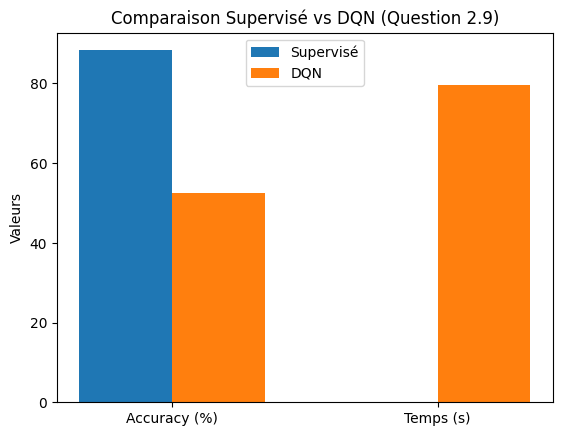

In [19]:
print(f"\nCOMPARAISON FINALE :")
print(f"Supervisé - Accuracy: {accuracy*100:.2f}% | Temps: {training_time:.2f}s")
print(f"DQN       - Accuracy: {acc_dqn*100:.2f}% | Temps: {time_dqn:.2f}s")

# Graphique des performances
labels = ['Accuracy (%)', 'Temps (s)']
sup_metrics = [accuracy * 100, training_time]
dqn_metrics = [acc_dqn * 100, time_dqn]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, sup_metrics, width, label='Supervisé')
ax.bar(x + width/2, dqn_metrics, width, label='DQN')

ax.set_ylabel('Valeurs')
ax.set_title('Comparaison Supervisé vs DQN (Question 2.9)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

Notre modèle d'agent suppervisé est meilleur que le DQn adapté à cet effet. En effet notre MLP est fait pour de la classification, il est donc plus adapté ici que notre agent qui apprend avec un système de récompense.

## Conclusion
Ce projet nous à permis de decouvrir les Q-Network et leurs fonctionnement, tout en réalisant une interface visuele d'apprentissage